# Multiple Linear Regression

Multiple Linear Regression (MLR) is a fundamental statistical method in Data Science used to model the relationship between a dependent variable (target) and multiple independent variables (features). Unlike Simple Linear Regression, MLR allows us to account for multiple predictors simultaneously, making it more powerful for real-world datasets where multiple factors influence the outcome. 

Since in the [Linear Regression](LinearRegression.ipynb) notebook we covered the more basic concepts, here we will delve into sconcepts such as the changed key metrics (such as Adjusted R-quared), testing the significance of the model, OLS Assumptions and Dummy Variables.

## Index


**Libraries used:**

In [6]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing
from scipy.stats import probplot
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor

## 1. The Multiple Linear Regression Model

The formula for the MLR is an extension form of the simple Linear Regression formula:

$$
Y = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + ... + \beta_p X_p + \epsilon
$$

where Y is the target (dependent) variable, $X_1, X_2, ..., X_p$ are the features (independent variables), $\beta_0$ is the intercept term, $\beta_1, \beta_2, ..., \beta_p$ are the coefficients and $\epsilon$ is the error term (residuals).

For this notebook, we will work on seaborns **California Housing Dataset**:

In [2]:
# Load dataset
california = fetch_california_housing()
df = pd.DataFrame(california.data, columns=california.feature_names)
df['MedHouseVal'] = california.target

# Fit MLR model
model = ols('MedHouseVal ~ MedInc + HouseAge + AveRooms + AveBedrms + Population + AveOccup + Latitude + Longitude', data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            MedHouseVal   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.606
Method:                 Least Squares   F-statistic:                     3970.
Date:                Wed, 16 Apr 2025   Prob (F-statistic):               0.00
Time:                        16:03:17   Log-Likelihood:                -22624.
No. Observations:               20640   AIC:                         4.527e+04
Df Residuals:                   20631   BIC:                         4.534e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -36.9419      0.659    -56.067      0.0

## 2. Adjusted R-squared

Since $R^2$ measures the proportion of variance explained by the model, the adjusted version of this metric penalizes the aaddition of unnecessary predictors:

$$
Adjusted R^2 = 1 - \frac{(1- R^2) (n-1)}{n-p-1}
$$

where $n$ is the number of observations and $p$ is the number of predictors. A higher Adjusted $R^2$ assumes a better model fit and is preferable over the simple $R^2$ when comparing models.

In [3]:
print(f"R-squared: {model.rsquared:.4f}")
print(f"Adjusted R-squared: {model.rsquared_adj:.4f}")

R-squared: 0.6062
Adjusted R-squared: 0.6061


## 3. Test for Significance of the Model (F-Test)

This is a simple statistical hypothesis test:

- **Null Hypothesis ($H_0$):** All coefficients are zero (no predictive power);
- **Alternative Hypothesis ($H_1$):** At least one coefficient is non-zero.

We then calculate the F-statistic = $\frac{MSR}{MSE} (\frac{Explained Variance}{Unexplained Variance})$, where MSR is the Mean Squared Regression and the MSE term is the Mean Squared Error. When the p-value (P(F-Statistic)) is lower than 0.05, we reject $H_0$:

In [4]:
print(f"F-statistic: {model.fvalue:.2f}")
print(f"Prob (F-statistic): {model.f_pvalue:.4f}")

F-statistic: 3970.36
Prob (F-statistic): 0.0000


## 4. OLS Assumptions

As seen previously, the OLS is widely used as a regression estimation method. While we defined its concept, it is also understood that it implies some assumptions:

1. **Linearity:** The relationship between predictors and target should be linear. We can check and compare the Residuals with the fitted plot (it should show no pattern)

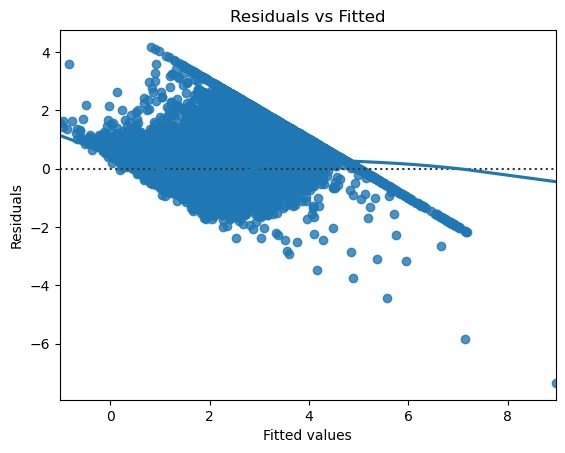

In [5]:
sns.residplot(x=model.fittedvalues, y=model.resid, lowess=True)
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted")
plt.show()

**NOTE:** THIS PLOT, DUE TO THE RESIDUALS APPEARING TO FAN OUT AS FITTED VALUES INCREASE, SUGGESTS HETEROSCEDASTICITY (NON-CONSTANT VARIANCE IN RESIDUALS) THIS REPRESENTS AN OLS ASSUMPTION VIOLATION, SO THE DATA NEEDS TO BE WORKED BEFORE APPLYING THE MODEL.

2. **No Endogeneity:** There should be no omitted variable bias (error term should not correlate with predictors). We can check it by running a Hausman test
3. **Normality & Homoscedasticity:** Respectively, residuals should be normally distributed and there should be a constant residual variance.

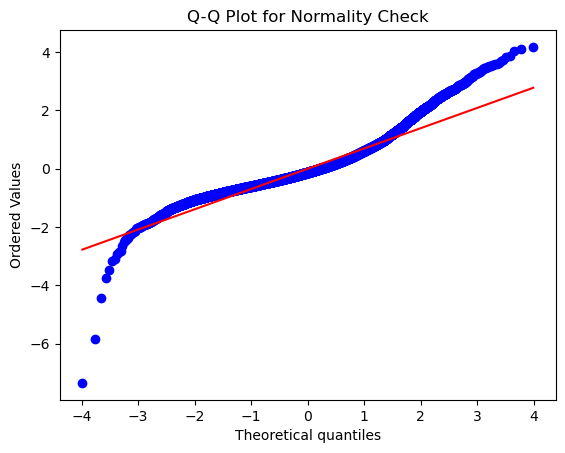

In [7]:
probplot(model.resid, plot=plt)
plt.title("Q-Q Plot for Normality Check")
plt.show()

In [8]:
# Breusch-Pagan test for heteroscedasticity
_, p_val, _, _ = het_breuschpagan(model.resid, model.model.exog)
print(f"Breusch-Pagan p-value: {p_val:.4f}")  # p > 0.05 → Homoscedastic

Breusch-Pagan p-value: 0.0000


4. **No Autocorrelation:** Residuals should not be correlated, which is important in time-series data, for example. We check it by running a Durbin-Watson test (DW ≈ 2 → No autocorrelation).

In [9]:
print(f"Durbin-Watson: {durbin_watson(model.resid):.2f}")

Durbin-Watson: 0.89
